## Import Library

In [6]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [7]:
df = pd.read_csv('sms_spam.csv')
df

,Unnamed: 0,v1,v2
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,5567,spam,This is the 2nd time we have tried 2 contact u...
5568,5568,ham,Will _ b going to esplanade fr home?
5569,5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,5570,ham,The guy did some bitching but I acted like i'd...


## Data Cleaning

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5572 non-null   int64 
 1   v1          5572 non-null   object
 2   v2          5572 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [9]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [10]:
df.rename(columns={'v1':'Type','v2':'Message'},inplace=True)
df.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
label_encoder = LabelEncoder()

df['Type'] = label_encoder.fit_transform(df['Type'])

df.head()

,Type,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
print(label_encoder.classes_)

['ham' 'spam']


**Check for missing values**

In [13]:
df.isnull().sum()

Type       0
Message    0
dtype: int64

**Check for duplicate values**

In [14]:
df.duplicated().sum()

np.int64(404)

In [15]:
df = df.drop_duplicates(keep='first')
df.shape

(5168, 2)

## Data Preprocessing

In [25]:
nltk.download("stopwords")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /home/xyz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/xyz/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [21]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

set lookup: O(1) time (fast)

list lookup: O(n) time (slow if the list is long)

In [22]:
len(stop_words)

198

In [29]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    token = []

    for word in tokens:
        if word.isalnum() :
            token.append(word)
    return ' '.join(token)    

In [30]:
df['Preprocessed_text'] = df['Message'].apply(preprocess)

In [31]:
df

,Type,Message,Preprocessed_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i do think he goes to usf he lives around ...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,0,Will _ b going to esplanade fr home?,will b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other suggest...
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i b...


## Model Building and Testing

Here spam = 1 and ham = 0  
i.e.  spam = positive class and ham = negative class

In confusion matrix,    
**TP** = Spam predicted as spam    
**FP** = Ham wrongly predicted as spam    
**FN** = Spam wrongly predicted as ham    
**TN** = Ham correctly predicted as ham   

Our goal is classify in such a way that **Ham cannot wrongly predicted as spam**  or  **Predictio of Ham wrongly as spam must be very less**    

That's why we try to make ourr accuracy is higher with precision as 1 or almost near 1

**Generate all variations for spam messages**

In [47]:
from googletrans import Translator

translator = Translator()
langs = ['de', 'fr', 'es', 'it']  # German, French, Spanish, Italian

def multi_back_translate(text, langs=langs):
    variations = []
    for lang in langs:
        try:
            # Translate EN → target language
            mid_text = translator.translate(text, src='en', dest=lang).text

            # Translate back target language → EN
            back_text = translator.translate(mid_text, src=lang, dest='en').text

            # Make lowercase
            variations.append(back_text.lower())
        except:
            continue
    return variations

In [48]:
X = df['Preprocessed_text']
y = df['Type']

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

In [50]:
import pandas as pd

# Convert y_train into a pandas Series
y_train_series = pd.Series(y_train)

# Now check counts
print(y_train_series.value_counts())


Type
0    3612
1     522
Name: count, dtype: int64


In [51]:
train_df = pd.DataFrame({"Message": X_train, "Type": y_train})

In [52]:
train_df

,Message,Type
5010,you have won a guaranteed 1000 cash or a 2000 ...,1
1095,ryder gibbs,0
742,just got up have to be out of the room very so...,0
3005,also hi wesley how you been,0
4475,i pick you up at about to go to taunton if you...,0
...,...,...
4139,leave it wif me lar wan to carry meh so heavy ...,0
4736,nt only for driving even for many reasons she ...,0
124,predict wat time finish buying,0
185,hello handsome are you finding that job not be...,0


**Apply to spam messages only**

In [53]:
spam_df = train_df[train_df["Type"] == 1]

In [54]:
spam_df

,Message,Type
5010,you have won a guaranteed 1000 cash or a 2000 ...,1
765,ur awarded a city break and could win a 200 su...,1
1377,double mins double txt price linerental on lat...,1
1047,1000 flirting now txt girl or bloke ur name ag...,1
1457,claire here am havin borin time am now alone u...,1
...,...,...
417,free entry into our 250 weekly competition jus...,1
5025,ur is currently 500 pounds to maximize ur now ...,1
2555,freemsg you have been awarded a free mini digi...,1
832,dear voucher holder to claim this weeks offer ...,1


In [55]:
text = spam_df['Message'].iloc[0]

In [56]:
multi_back_translate(text)

['you have won a guaranteed 1000 bar or a 2000 price to request the yr prize price',
 'you have won a price of 1000 in guaranteed cash or a 2000 price to claim the yr price call our customer service representative on 08714712412 between 10p cost',
 'he has won a 1000 prize in cash or a 2000 prize to claim the award of his year.call our customer service representative at 08714712412 between cost 10p',
 'you have won a 1000 guaranteed cash prizes or a 2000 prize to request the yr award call our customer service representative at 08714712412 between the cost 10p']

In [57]:
augmented_spam = []
for msg in spam_df["Message"]:
    variations = multi_back_translate(msg)
    for v in variations:
        augmented_spam.append([v, 1])

In [58]:
augmented_spam_df = pd.DataFrame(augmented_spam, columns=["Message", "Type"])
augmented_spam_df['Message'] = augmented_spam_df['Message'].str.lower()

In [59]:
augmented_spam_df

,Message,Type
0,you have won a guaranteed 1000 bar or a 2000 p...,1
1,you have won a price of 1000 in guaranteed cas...,1
2,he has won a 1000 prize in cash or a 2000 priz...,1
3,you have won a 1000 guaranteed cash prizes or ...,1
4,ur gave a city period,1
...,...,...
2074,dear voucher owner to request this week's offe...,1
2075,your 2004 account for 07xxxxxxxxxx shows 786 n...,1
2076,your account 2004 for 07xxxxxxxxx posters 786 ...,1
2077,its 2004 account for 07xxxxxxxxx shows 786 poi...,1


**Merge back into training set**

In [60]:
train_df_augmented = pd.concat([train_df, augmented_spam_df], ignore_index=True)
train_df_augmented

,Message,Type
0,you have won a guaranteed 1000 cash or a 2000 ...,1
1,ryder gibbs,0
2,just got up have to be out of the room very so...,0
3,also hi wesley how you been,0
4,i pick you up at about to go to taunton if you...,0
...,...,...
6208,dear voucher owner to request this week's offe...,1
6209,your 2004 account for 07xxxxxxxxxx shows 786 n...,1
6210,your account 2004 for 07xxxxxxxxx posters 786 ...,1
6211,its 2004 account for 07xxxxxxxxx shows 786 poi...,1


In [61]:
X_train_new1 = train_df_augmented['Message']
y_train_new = train_df_augmented['Type']

In [62]:
import pandas as pd

# Convert y_train into a pandas Series
y_train_new_series = pd.Series(y_train_new)

# Now check counts
print(y_train_new_series.value_counts())


Type
0    3612
1    2601
Name: count, dtype: int64


In [63]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_stop_stem(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Tokenize
    tokens = nltk.word_tokenize(text)
    
    # 3. Filter + stem
    filtered = []
    for word in tokens:
        if word.isalnum() and word not in stop_words:
            stemmed = stemmer.stem(word)
            filtered.append(stemmed)
    
    # 4. Reconstruct
    return " ".join(filtered)

In [64]:
X_train_new = X_train_new1.apply(preprocess_stop_stem)
X_train_new

0       guarante 1000 cash 2000 prize claim yr prize c...
1                                              ryder gibb
2       got room soon put clock back til 8 shout every...
3                                          also hi wesley
4                         pick go taunton still want come
                              ...                        
6208    dear voucher owner request week offer pc pleas...
6209    2004 account 07xxxxxxxxxx show 786 reduc point...
6210    account 2004 07xxxxxxxxx poster 786 point reis...
6211    2004 account 07xxxxxxxxx show 786 point redeem...
6212    2004 account 07xxxxxxxx exhibit 786 point redu...
Name: Message, Length: 6213, dtype: object

In [ ]:
# Apply preprocessing on training messages
X_train_new = train_df_augmented['Message'].apply(preprocess_stop_stem)


In [65]:
X_test

464                         ok i am on the way to railway
591     you have been specially selected to receive a ...
4818                    got smaller capacity one quite ex
3366                 hey what are you doing y no reply pa
151     yup i thk cine is better cos no need 2 go down...
                              ...                        
884     yoyyooo u know how to change permissions for a...
2298    dont pick up d call when something important i...
3811                      yep then is fine or for ice age
1328         my exam is for february wish you a great day
4129                      and by when you done i mean now
Name: Preprocessed_text, Length: 1034, dtype: object

In [66]:
X_test = X_test.apply(preprocess_stop_stem)
X_test

464                                        ok way railway
591     special select receiv 2000 pound award call 08...
4818                        got smaller capac one quit ex
3366                                         hey repli pa
151          yup thk cine better co need 2 go 2 plaza mah
                              ...                        
884     yoyyooo u know chang permiss drive mac usb fla...
2298             dont pick call someth import tell hrishi
3811                                     yep fine ice age
1328                         exam februari wish great day
4129                                            done mean
Name: Preprocessed_text, Length: 1034, dtype: object

**Text Vectorization using TF-IDF (Unigrams & Bigrams)**

In [67]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000,ngram_range=(1,2))

In [68]:
# Fit only on augmented training set
X_train_vec = tfidf.fit_transform(X_train_new).toarray()

# Transform the untouched test set with the same vectorizer
X_test_vec = tfidf.transform(X_test).toarray()

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [70]:
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [71]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'M_NB': mnb,
    'B_NB': bnb, 
    'G_NB': gnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')  # use 'binary' for 0/1 or 'macro' for multi-class
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    report = classification_report(y_test, y_pred)
    
    return acc, prec, rec, f1, report

In [73]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision, current_recall, current_f1, current_report = train_classifier(
        clf, X_train_vec, y_train_new, X_test_vec, y_test
    )
    
    print(f"\nFor {name}:")
    print("Accuracy -", current_accuracy)
    print("Precision -", current_precision)
    print("Recall -", current_recall)
    print("F1-score -", current_f1)
    print("Classification Report:\n", current_report)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)


For SVC:
Accuracy - 0.9729206963249516
Precision - 0.8863636363636364
Recall - 0.9
F1-score - 0.8931297709923665
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       904
           1       0.89      0.90      0.89       130

    accuracy                           0.97      1034
   macro avg       0.94      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034


For KN:
Accuracy - 0.9381044487427466
Precision - 1.0
Recall - 0.5076923076923077
F1-score - 0.673469387755102
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97       904
           1       1.00      0.51      0.67       130

    accuracy                           0.94      1034
   macro avg       0.97      0.75      0.82      1034
weighted avg       0.94      0.94      0.93      1034


For M_NB:
Accuracy - 0.9642166344294004
Precision - 0.8345323741007195


In [74]:
import pandas as pd

# Create performance DataFrame
performance_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
})

# Sort by F1-score descending
performance_df = performance_df.sort_values('Precision', ascending=False)

# Reset index for cleaner display
performance_df = performance_df.reset_index(drop=True)

print(performance_df)

   Algorithm  Accuracy  Precision    Recall  F1-score
0         KN  0.938104   1.000000  0.507692  0.673469
1       B_NB  0.982592   0.991228  0.869231  0.926230
2        ETC  0.978723   0.935484  0.892308  0.913386
3         RF  0.977756   0.928000  0.892308  0.909804
4       G_NB  0.975822   0.888889  0.923077  0.905660
5        SVC  0.972921   0.886364  0.900000  0.893130
6       M_NB  0.964217   0.834532  0.892308  0.862454
7         LR  0.962282   0.818182  0.900000  0.857143
8        xgb  0.957447   0.816176  0.853846  0.834586
9        BgC  0.943907   0.730769  0.876923  0.797203
10      GBDT  0.932302   0.705479  0.792308  0.746377
11        DT  0.925532   0.685315  0.753846  0.717949
12  AdaBoost  0.904255   0.596273  0.738462  0.659794


In [75]:
performance_df

,Algorithm,Accuracy,Precision,Recall,F1-score
0,KN,0.938104,1.000000,0.507692,0.673469
1,B_NB,0.982592,0.991228,0.869231,0.926230
2,ETC,0.978723,0.935484,0.892308,0.913386
3,RF,0.977756,0.928000,0.892308,0.909804
4,G_NB,0.975822,0.888889,0.923077,0.905660
5,SVC,0.972921,0.886364,0.900000,0.893130
6,M_NB,0.964217,0.834532,0.892308,0.862454
7,LR,0.962282,0.818182,0.900000,0.857143
8,xgb,0.957447,0.816176,0.853846,0.834586
9,BgC,0.943907,0.730769,0.876923,0.797203


**Voting Classifier**

In [77]:
from sklearn.ensemble import VotingClassifier

In [78]:
voting = VotingClassifier(estimators=[('RF', rfc), ('B_NB', bnb), ('G_NB', gnb),('et',etc)],voting='soft')

Accuracy: 0.9835589941972921
Precision: 0.9669421487603306
Recall: 0.9
F1 Score: 0.9322709163346613

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       904
           1       0.97      0.90      0.93       130

    accuracy                           0.98      1034
   macro avg       0.98      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



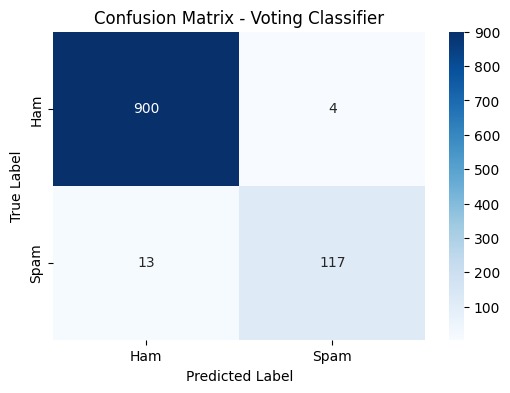

In [79]:
voting.fit(X_train_vec,y_train_new)

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = voting.predict(X_test_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()


ROC AUC Score: 0.9849387338325392


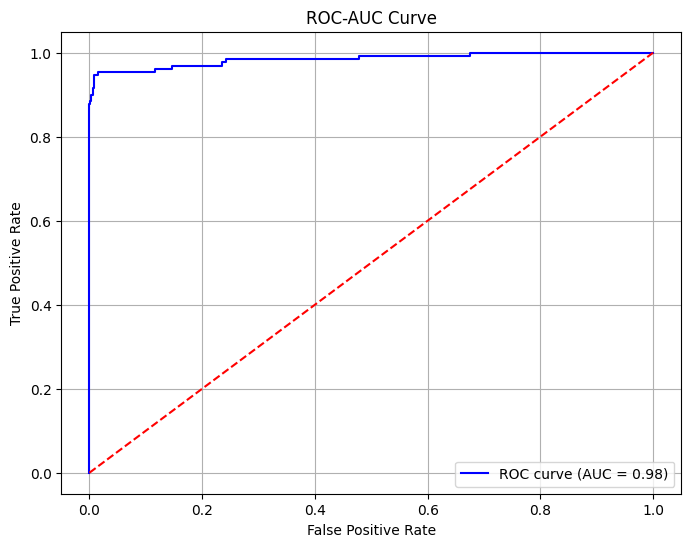

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for positive class (Spam = 1)
y_prob = voting.predict_proba(X_test_vec)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Applying stacking**

In [81]:
from sklearn.ensemble import StackingClassifier

In [84]:
final_estimator=RandomForestClassifier()

clf = StackingClassifier(estimators=[('Rf',rfc), ('B_NB', bnb), ('G_NB', gnb),('et',etc)], final_estimator=final_estimator)

In [85]:
clf.fit(X_train_vec,y_train_new)

,estimators,"[('Rf', ...), ('B_NB', ...), ...]"
,final_estimator,RandomForestClassifier()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2


Accuracy: 0.9816247582205029
Precision: 0.9172932330827067
Recall: 0.9384615384615385
F1 Score: 0.9277566539923955

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.92      0.94      0.93       130

    accuracy                           0.98      1034
   macro avg       0.95      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



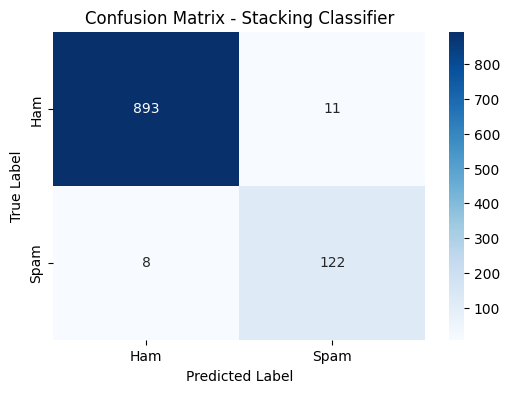

In [86]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions using StackingClassifier
y_pred_stack = clf.predict(X_test_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

# Confusion matrix
cm_stack = confusion_matrix(y_test, y_pred_stack)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(
    cm_stack, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()


ROC AUC Score: 0.9721792035398231


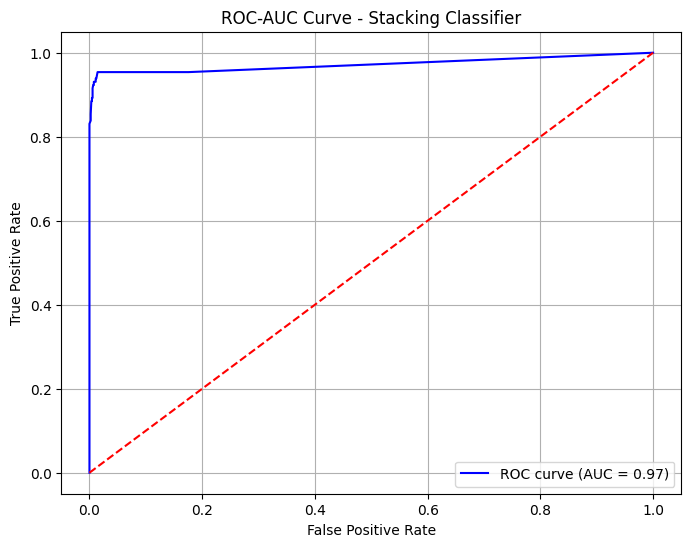

In [87]:
# Get predicted probabilities for positive class (Spam = 1)
y_prob_stack = clf.predict_proba(X_test_vec)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_stack)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve - Stacking Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
